# Intent Classification with Keras
In my past notebooks, my goal was to recieve my labeled data for my chatbot. Now this notebook focuses on using Keras to classify intents of new, unseen data that a user might type up. The model now switched to a supervised learning approach now that we generated the labels from the unsupervised learning we did in the previous notebook.

### Rasa Comparison
Rasa trains this intent classification step with SVM and GridsearchCV because they can try different configurations ([source](https://medium.com/bhavaniravi/intent-classification-demystifying-rasanlu-part-4-685fc02f5c1d)). When deploying preprocessing pipeline should remain same between train and test.

In [5]:
# Data science
import pandas as pd
print(f"Pandas: {pd.__version__}")
import numpy as np
print(f"Numpy: {np.__version__}")

# Deep Learning 
import tensorflow as tf
print(f"Tensorflow: {tf.__version__}")
from tensorflow import keras
print(f"Keras: {keras.__version__}")
import sklearn
print(f"Sklearn: {sklearn.__version__}")

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

import collections
import yaml

# Preprocessing and Keras
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import re
import os
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# Reading back in intents
with open(r'objects/intents.yml') as file:
    intents = yaml.load(file, Loader=yaml.FullLoader)

# Reading in representative intents
with open(r'objects/intents_repr.yml') as file:
    intents_repr = yaml.load(file, Loader=yaml.FullLoader)
    
# Reading in training data
train = pd.read_pickle('objects/train.pkl')

print(train.head())
print(f'\nintents:\n{intents}')
print(f'\nrepresentative intents:\n{intents_repr}')

Pandas: 1.0.5
Numpy: 1.18.5
Tensorflow: 2.2.0
Keras: 2.3.0-tf
Sklearn: 0.23.1


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



                                           Utterance           Intent
0  [phone, battery, die, fast, within, hour, usag...          battery
1                                 [forgot, my, pass]  forgot_password
2                            [payment, not, through]          payment
3                                     [want, update]           update
4                                [need, information]             info

intents:
{'battery': ['battery', 'power'], 'forgot_password': ['password', 'account', 'login'], 'payment': ['credit', 'card', 'payment', 'pay'], 'repair': ['repair', 'fix', 'broken'], 'update': ['update']}

representative intents:
{'battery': ['battery', 'power'], 'forgot_password': ['password', 'account', 'login'], 'info': ['info', 'information'], 'location': ['nearest', 'apple', 'location', 'store'], 'payment': ['credit', 'card', 'payment', 'pay'], 'update': ['update', 'upgrade']}


# Keras Preprocessing

### Keras Tokenizer
Creates a dictionary of all the words in the vocab, and it stores the index. For each sequence it passes in the sequence and converts each word into the index that refers to the Keras word dictionary. When you feed in sentences into the model, they all have to be the same length. But some tweets are going to be longer than others, so pad_sequences just pad all the other ones so they are on the same length. It padding the messages with 0s until they are the same length as the longest message. They might set a max-length that are shorter because longer sequences are harder to train on.

I've done most of the main preprocessing work, but Keras needs some more specific things for to model with it.

In [51]:
# Defining all required functions
def make_tokenizer(docs, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    t = Tokenizer(filters = filters)
    t.fit_on_texts(docs)
    return t

encode_tweets = lambda token, words: token.texts_to_sequences(words)
get_max_token_length = lambda series: len(max(series, key = len))
pad_tweets = lambda encoded_doc, max_length: pad_sequences(encoded_doc, maxlen = max_length, padding = "post")
one_hot = lambda encode: OneHotEncoder(sparse = False).fit_transform(encode)

# 1. Create tokenizer object
token = make_tokenizer(train['Utterance'])

# 2. Finding length of vocabulary
vocab_size = len(token.word_index) + 1

# 3. Finding maximum length of Tokens

max_token_length = get_max_token_length(train['Utterance'])

print(f'Vocab Size: {vocab_size} \nMax Token Length: {max_token_length}')

# 4. Encode documents - matching with Keras dictionary
encoded_tweets = encode_tweets(token, train['Utterance'])

# 5. Padding my documents - filling with tags to normalize the lengths
padded_tweets = pad_tweets(encoded_tweets, max_token_length)
print("Shape of padded tweets:",padded_tweets.shape)
print("\nPreview of encoded and padded tweets:\n", padded_tweets)

# 6. One hot encode to represent target variable data (intents)
unique_intents = list(set(train['Intent']))
unique_intents = sorted(unique_intents)

# Making another tokenizer
output_tokenizer = make_tokenizer(unique_intents, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')
encoded_intents = encode_tweets(output_tokenizer, train['Intent'])

# Reshaping encoded Tweets for this one hot function
encoded_intents = np.array(encoded_intents).reshape(len(encoded_intents), 1)
one_hot_intents = one_hot(encoded_intents)
print(f'\nPreview of intent representation:\n{one_hot_intents}')

# 7. Split in to train and test
X_train, X_val, y_train, y_val = train_test_split(padded_tweets, one_hot_intents, test_size = 0.3, 
                                                   shuffle = True, stratify = one_hot_intents)
print(f'\nShape checks:\nX_train: {X_train.shape} X_val: {X_val.shape}\ny_train: {y_train.shape} y_val: {y_val.shape}')

Vocab Size: 4746 
Max Token Length: 32
Shape of padded tweets: (10000, 32)

Preview of encoded and padded tweets:
 [[  5   4 134 ...   0   0   0]
 [ 41  43  92 ...   0   0   0]
 [ 90  21 148 ...   0   0   0]
 ...
 [ 17  77   0 ...   0   0   0]
 [ 69   0   0 ...   0   0   0]
 [ 12  11   0 ...   0   0   0]]

Preview of intent representation:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]

Shape checks:
X_train: (7000, 32) X_val: (3000, 32)
y_train: (7000, 10) y_val: (3000, 10)


In [11]:
train

,Utterance,Intent
0,"[phone, battery, die, fast, within, hour, usag...",battery
1,"[forgot, my, pass]",forgot_password
2,"[payment, not, through]",payment
3,"[want, update]",update
4,"[need, information]",info
...,...,...
9995,"[incomplete, display, render, related, bogus, ...",location
9996,"[talk, human, please]",speak_representative
9997,"[good, morning]",greeting
9998,[done],goodbye


In [8]:
encoded_intents[:11]

array([[ 1],
       [ 3],
       [ 8],
       [10],
       [ 6],
       [ 7],
       [ 9],
       [ 5],
       [ 4],
       [ 2],
       [ 1]])

In [12]:
sorted(train.Intent[:10])

['battery',
 'challenge_robot',
 'forgot_password',
 'goodbye',
 'greeting',
 'info',
 'location',
 'payment',
 'speak_representative',
 'update']

### Embedding matrix

Keras models look for y variables to be one hot encoded. When it's multiclass many people feed it as one hot encoded vectors. It's just one of the design choices.

If you're using doc2vec embeddings, how do you pass in your Tweets. You may have to pass it in as full tweets. Check how you pass in the Tweets. You may have to tokenize at a Tweet level. If you pass it in, if it's Tweet 57, it will activate the node such that it gets multiplied out by the embeddings for the 57th document.

In [13]:
# Making my own embedding matrix that's in a specific order
d2v_embedding_matrix = pd.read_pickle('objects/inbound_d2v.pkl')

In [241]:
# We can see that there are 4 different dimensionality options
!ls models/glove.twitter.27B

glove.twitter.27B.100d.txt glove.twitter.27B.25d.txt
glove.twitter.27B.200d.txt glove.twitter.27B.50d.txt


Here, we compute an index mapping words to known embeddings by parsing the data dump of pre-trained embeddings:

In [14]:
# Using gloVe word embeddings
embeddings_index = {}
f = open('models/glove.twitter.27B/glove.twitter.27B.25d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


Now we can leverage our embedding_index dictionary and our word_index to compute our embedding matrix:

In [15]:
# Initializing required objects
word_index = token.word_index
EMBEDDING_DIM = 25 # Because we are using the 25D gloVe embeddings

# Getting my embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [16]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.45120001, -0.24502   ,  0.18376   , ...,  0.76213998,
         0.30982   , -0.49316999],
       [ 0.69946003,  0.75647002,  0.027693  , ..., -0.24399   ,
         0.061082  , -0.59698999],
       ...,
       [ 0.87431002,  1.04569995, -0.20902   , ...,  0.76419997,
        -0.87015998, -0.73815   ],
       [-0.61260003,  0.063154  , -0.20061   , ...,  1.38769996,
         0.65736997, -0.42660001],
       [-0.22751001,  0.40937999,  0.22876   , ...,  0.046516  ,
         0.38591999, -0.79839998]])

Great, now we can start the modelling.

In a regular word embedding, the order of the embeddings in the matrix has to be setup so that it matches how the words appear in my keras tokenizer word index. It does it so that the most common words appear up front, and the embedding matrix needs to be aligned.

I also made sure the order of the embeddings are the same order of the words in my model.

Here, I also made sure that domain-specific words like macbook is in my Twitter embeddings. One example of this is 'macbook' and you can clearly see that it is indeed in the embeddings file, which is good:

<img src="visualizations/macbook-glove.png" alt="Drawing" style="width: 400px;"/>

# Keras Modelling
I will create a neural network with Keras with the output layer having the same number of nodes as there are intents. The following is my architecture:

In [19]:
def make_model(vocab_size, max_token_length):
    ''' In this function I define all the layers of my neural network'''
    # Initialize
    model = Sequential()
    
    # Adding layers - For embedding layer, I made sure to add my embedding matrix into the weights paramater
    model.add(Embedding(vocab_size, embedding_matrix.shape[1], input_length = max_token_length, 
                        trainable = False, weights = [embedding_matrix]))
    model.add(Bidirectional(LSTM(128)))
    # Another LSTM layer. If things aren't doing well. Beef up the dense layer size.
#    model.add(LSTM(128)) 
    # Try 100
    model.add(Dense(600, activation = "relu",kernel_regularizer='l2')) # Try 50, another dense layer? This takes a little bit of exploration
    
    # Adding another dense layer to increase model complexity
    model.add(Dense(600, activation = "relu",kernel_regularizer='l2'))
    
    # Only update 50 percent of the nodes - helps with overfitting
    model.add(Dropout(0.5))
    
    # This last layer should be the size of the number of your intents!
    # Use sigmoid for multilabel classification, otherwise, use softmax!
    model.add(Dense(10, activation = "softmax"))
    
    return model

# Actually creating my model
model = make_model(vocab_size, max_token_length)
model.compile(loss = "categorical_crossentropy", 
              optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 25)            118650    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               157696    
_________________________________________________________________
dense_3 (Dense)              (None, 600)               154200    
_________________________________________________________________
dense_4 (Dense)              (None, 600)               360600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                6010      
Total params: 797,156
Trainable params: 678,506
Non-trainable params: 118,650
__________________________________________

In [20]:
# Initializing checkpoint settings to view progress and save model
filename = 'models/intent_classification_a.h5'

# Learning rate scheduling
# This function keeps the initial learning rate for the first ten epochs  
# and decreases it exponentially after that.  
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_sched_checkpoint = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


# This saves the best model
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

# The model you get at the end of it is after 100 epochs, but that might not have been
# the weights most associated with validation accuracy

# Only save the weights when you model has the lowest val loss. Early stopping

# Fitting model
hist = model.fit(X_train, y_train, epochs = 50, batch_size = 32, 
                 validation_data = (X_val, y_val), 
                 callbacks = [checkpoint, lr_sched_checkpoint, early_stopping])

Epoch 1/50
219/219 [==============================] - ETA: 0s - loss: 2.3808 - accuracy: 0.6454
Epoch 00001: val_loss improved from inf to 0.78972, saving model to models/intent_classification_a.h5
219/219 [==============================] - 37s 169ms/step - loss: 2.3808 - accuracy: 0.6454 - val_loss: 0.7897 - val_accuracy: 0.7843 - lr: 0.0010
Epoch 2/50
219/219 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.8216
Epoch 00002: val_loss improved from 0.78972 to 0.65681, saving model to models/intent_classification_a.h5
219/219 [==============================] - 22s 102ms/step - loss: 0.6974 - accuracy: 0.8216 - val_loss: 0.6568 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 3/50
219/219 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.8356
Epoch 00003: val_loss improved from 0.65681 to 0.58559, saving model to models/intent_classification_a.h5
219/219 [==============================] - 22s 100ms/step - loss: 0.6032 - accuracy: 0.8356 - val_loss: 

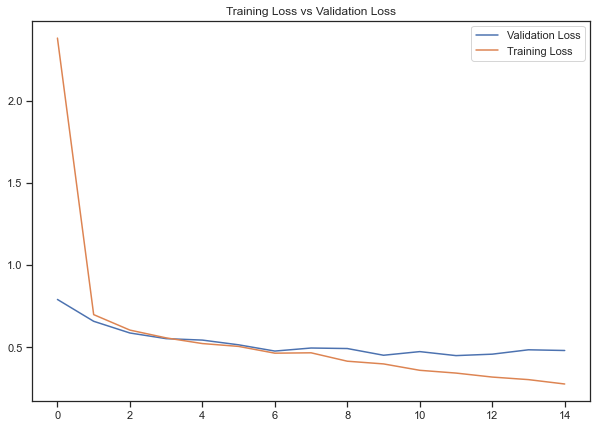

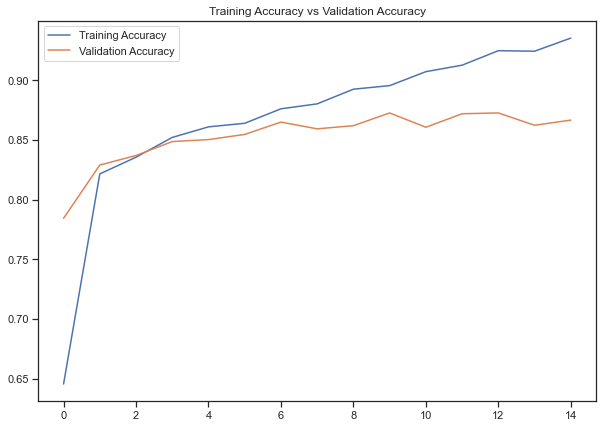

In [21]:
# Visualizing Training Loss vs Validation Loss (the loss is how wrong your model is)
plt.figure(figsize=(10,7))
plt.plot(hist.history['val_loss'], label = 'Validation Loss')
plt.plot(hist.history['loss'], label = 'Training Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.show()

# Visualizing Testing Accuracy vs Validation Accuracy
plt.figure(figsize=(10,7))
plt.plot(hist.history['accuracy'], label = 'Training Accuracy')
plt.plot(hist.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend()
plt.show()

At after 20 epochs, the slope becomes a flat line, not really much change in the loss. Floor effect is you can't get any lower than 0 loss. It really quickly learns from the training data what it needs to learn. If you continue to train, you're basically overfitting to the training data, you're fitting to the unimportant signal.

For example, in the context of images, if the model learns to recognize what a cat is, it might now be too detailed and learn that cats have to be the color black as well.

### Model improvements
The model overfits at a low epoch. Model is significantly overfitting. Plot out accuracies.

Don't need 100 training epoch.

Look at learning rate scheduling, after certain number of epochs, decrease learning rate.
* Learning rate scheduling
* Early stopping or reducing epochs
* Dropout layers
* Regularization
* Improve distinctiveness between intent data

After I have applied these improvements, my accuracy went up.

In [22]:
# I have to redefine and load in the model saved by my model checkpoint 
from keras.models import load_model
model = load_model('models/intent_classification_a.h5')

In [46]:
def infer_intent(text):
    ''' Takes as input an utterance an outputs a dictionary of intent probabilities '''
    # Making sure that my text is a string
    string_text = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
    
    # Converting to Keras form
    keras_text = token.texts_to_sequences(string_text)

    # Check for and remove unknown words - [] indicates that word is unknown
    if [] in keras_text:
        # Filtering out
        keras_text = list(filter(None, keras_text))
    keras_text = np.array(keras_text).reshape(1, len(keras_text))
    x = pad_tweets(keras_text, max_token_length)

    # Generate class probability predictions
    # You're using the overfit model to predict!
    intent_predictions = np.array(model.predict_proba(x)[0])
    pairs = list(zip(unique_intents, intent_predictions))
    print(pairs)
    dict_pairs = dict(pairs)
    # Output dictionary
    output = {k: v for k, v in sorted(dict_pairs.items(), key=lambda item: item[1], reverse = True)}
    
    return string_text, output

In [47]:
string_text, conf_dict = infer_intent("bye")
print(f'You: {string_text}')
print(f'Eve: \nIntents:{conf_dict}')

[('battery', 0.004495011), ('challenge_robot', 0.8240631), ('forgot_password', 0.0006804819), ('goodbye', 0.009609031), ('greeting', 0.12840441), ('info', 0.02369927), ('location', 0.004402823), ('payment', 5.983397e-05), ('speak_representative', 0.0012615188), ('update', 0.003324509)]
You: bye
Eve: 
Intents:{'challenge_robot': 0.8240631, 'greeting': 0.12840441, 'info': 0.02369927, 'goodbye': 0.009609031, 'battery': 0.004495011, 'location': 0.004402823, 'update': 0.003324509, 'speak_representative': 0.0012615188, 'forgot_password': 0.0006804819, 'payment': 5.983397e-05}


# Debugging: Label-to-probability Mapping
I had a huge problem trying to see if the labels are correctly mapped to it's respective intent probability. I try to debug step by step here:

In [35]:
# Converting to Keras form
input_text = 'hi babe'
keras_text = token.texts_to_sequences(input_text)
keras_text

[[780], [14], [], [513], [1413], [513], [573]]

In [36]:
# Check for and remove unknown words - [] indicates that word is unknown
if [] in keras_text:
# Filtering out
    keras_text = list(filter(None, keras_text))
keras_text = np.array(keras_text).reshape(1, len(keras_text))
keras_text

array([[ 780,   14,  513, 1413,  513,  573]])

In [37]:
x = pad_tweets(keras_text, max_token_length)
x

array([[ 780,   14,  513, 1413,  513,  573,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

In [38]:
a = ['a','a','a','a']
b = [1,4,3,2]

list(zip(a,b))

[('a', 1), ('a', 4), ('a', 3), ('a', 2)]

In [30]:
unique_intents

['battery',
 'challenge_robot',
 'forgot_password',
 'goodbye',
 'greeting',
 'info',
 'location',
 'payment',
 'speak_representative',
 'update']

In [39]:
y_prob = model.predict(x)[0]
y_prob

array([7.2700768e-03, 7.9997117e-06, 1.0893541e-02, 1.0051959e-05,
       3.0022514e-07, 6.2080952e-03, 7.2914976e-01, 2.3655701e-01,
       2.8477700e-03, 7.0553599e-03], dtype=float32)

In [40]:
y_classes = model.predict_proba(x)
y_classes

array([[7.2700768e-03, 7.9997117e-06, 1.0893541e-02, 1.0051959e-05,
        3.0022514e-07, 6.2080952e-03, 7.2914976e-01, 2.3655701e-01,
        2.8477700e-03, 7.0553599e-03]], dtype=float32)

In [45]:
encoded_intents[:10]

array([[ 1],
       [ 3],
       [ 8],
       [10],
       [ 6],
       [ 7],
       [ 9],
       [ 5],
       [ 4],
       [ 2]])

In [48]:
sorted(train.Intent[:10])

['battery',
 'challenge_robot',
 'forgot_password',
 'goodbye',
 'greeting',
 'info',
 'location',
 'payment',
 'speak_representative',
 'update']

In [49]:
unique_intents

['battery',
 'challenge_robot',
 'forgot_password',
 'goodbye',
 'greeting',
 'info',
 'location',
 'payment',
 'speak_representative',
 'update']

In [137]:
y_prob

array([[5.4813470e-05, 1.4960388e-02, 9.7874135e-01, 1.5970086e-03,
        1.4872276e-04, 1.3118163e-03, 3.0740418e-03, 1.2774575e-05,
        9.9173376e-05]], dtype=float32)

# Future Step: Multilabel Classification

In the future, if I want to recognize mixed intents in an utterance, I could do multilabel classification.

For multilabel classification, you use sigmoid activation function as the final layer. You'll still have ~10 distinct intents. But you need to modelled such that each of those intents are independent of each other.

Prediction of intent 1 shouldn't effect intent 2. Softmax takes all the scores over all classes, and the highest number will have highest probability output but everything will sum to 1. For the final softmax layer will sum to 1, but that doesn't work in my case.

But you're going to classify each intent separately. They can sum to greater than 1. 

It's similar to logreg in multiclass. One curve for class 0 and not class 0. The sum of those probs can be greater than 1.

For class 1, itll be 1 or not 1. Etc. You would look at your output layer, and whichever nodes have a greater probability output of >0.5, those 2 are your final output. You can do up to 3. Depends on how many nodes you will have.

When you feed in your target vector, they need to go into the one hot encoded vectors. Target column will have 10 columns. It will all sum up to one for each node. Each node will have a separate sigmoid function (P (1-P)). Across the nodes they're going to sum more than 1. One versus rest classification. Read up based on logreg terms. Multilabel classification. The main thing is your labels need to one hot encode. Loss function would use binary cross entropy.

Potential Issue: The more classes you have, the harder it is for your model. Especially for the 2nd and 3rd label that's when accs start to drop a bit.